# 2024-026 ATAC ORA Analysis

This notebook details processes for running ORA on differential peaks obtained from 2024-026 with previously established ChIP peaks.

**Expected Outputs**
 - CSV file of peak overlaps between ATAC-seq and ChIP-seq
 - CSV file of ORA results
 - rds of raw ClusterProfiler objects

## Initialize Environment

Import the necessary packages and output package versions:

In [1]:
# Load necessary libraries
library(ggplot2)
library(dplyr)
library(tibble)
library(tidyr)
library(GenomicRanges)
library(stringr)
library(clusterProfiler)

#### PARAMETERS ####
# Helper scripts
helpers         <- "/home/dalbao/2024-026-Tcf7ATAC/00_scripts/enrichmentScripts.R"

# Naming conventions
prefix          <- "DA-PORA-newCalc"

# Experimental parametes
peak_type       <- "broad_peak"

# Working directories
nb_dir          <- "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks"
chipset_dir     <- NULL
sigs_csv_dir    <- "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new"


# Data files
all_atac_bed    <- "/home/dalbao/2024-026-Tcf7ATAC/01_nfcore_241228/241231-filtered-mLb.bed"
daps_csv        <- "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/daps/250611-bp-DA-DAPS_noShrink_reduced-Unannotated.csv"

# Peak overlap parameters for bedtools intersect
fraction_a      <- 0.5  # Fraction of all_atac_bed peak
fraction_b      <- 0.8  # Fraction of chipset_peak

# bedtools intersect command
bedtools_intersect <- paste(
    "docker run --rm -v /home/dalbao:/home/dalbao -w $(pwd) -u $(id -u):$(id -g)",
    "staphb/bedtools:2.31.1",
    "bedtools intersect"
)

# All background peaks (boolean)
# If TRUE, use all_atac_bed as background peaks.
# If FALSE, use the peaks for which DESeq2 has successfully computed a statistic
all_background_peaks <- FALSE

# Save results?
savedata        <- TRUE

#### SETUP ENVIRONMENT ####
# Move to working directory
setwd(nb_dir)

# Source helper scripts
source(helpers)

# If peak_type == broad_peak, peak_sh is bp
peak_sh     <- ifelse(peak_type == "broad_peak", "bp", "np")

# Add peak type and date to prefix
prefix <- paste0(format(Sys.Date(), "%y%m%d"), "-", peak_sh, "-", prefix)

# Make a temporary directory for results
tmp_dir <- paste0("tmp_", prefix)
if (!dir.exists(tmp_dir)) {
    dir.create(tmp_dir)
}

# Make an output directory for results
out_dir <- paste0(prefix, "_results")
if (!dir.exists(out_dir)) {
    dir.create(out_dir)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attachi

## Generate Overlaps with ATAC-seq

First do bedtools intersect between ChIP and ATAC.

In [2]:
if (!is.null(chipset_dir)) {
    # Make vector of files in chipset_dir, and remove the .bed extension
    chipset_files <- list.files(chipset_dir, pattern = "\\.bed$", full.names = TRUE)
    chipset_files <- gsub("\\.bed$", "", basename(chipset_files))

    # Build list of shell commands
    commands <- character()
    for (chip in chipset_files) {
        chip_file <- file.path(chipset_dir, paste0(chip, ".bed"))
        output_file <- file.path(tmp_dir, paste0(chip, ".int"))

        cmd <- paste(
        bedtools_intersect,
        "-a", shQuote(all_atac_bed),
        "-b", shQuote(chip_file),
        "-wb -e -F", fraction_b,
        "-f", fraction_a,
        ">", shQuote(output_file)
        )
        commands <- c(commands, cmd)
    }

    # Write and execute with GNU parallel
    cmd_file <- tempfile("parallel_commands_", fileext = ".txt")
    writeLines(commands, cmd_file)
    system(paste("parallel --jobs 36 < ", shQuote(cmd_file)))  # adjust jobs as needed
}

Then read intersected bed files and generate peak sets:

In [3]:
if (!is.null(chipset_dir)) {
    # Read intersected bed files and generate peak sets
    peak_sets <- lapply(    chipset_files,
                            function(chip) {
        chip_file <- file.path(tmp_dir, paste0(chip, ".int"))

        if (file.exists(chip_file)) {
            # Read the intersected bed file
            df <- read.table(chip_file, header = FALSE, stringsAsFactors = FALSE)
            # Select first four columns and last four columns
            df <- df[, c(1:4, (ncol(df) - 3):ncol(df))]
            # Rename columns to distinguish between ATAC and ChIP
            bed_cols <- c("chr", "start", "end", "name")
            colnames(df) <- c(paste0(bed_cols, "_a"), paste0(bed_cols, "_b"))
            # Make column with ChIP name
            df$gs_name <- chip
            # Select only necessary columns
            # And rename columns for clarity
            df <- df %>%
                select(gs_name, name_a, name_b) %>%
                rename( atac_id = name_a,
                        chip_id = name_b)
        }
        else {
            df <- NULL
        }
        return(df)
    })

    # Collapse list of data frames into one data frame
    peak_sets <- bind_rows(peak_sets)
}

## Import Processed Peak Sets

In [4]:
if(!is.null(sigs_csv_dir)) {
    # Loop and load all CSV files that end with peak_sets.csv in the directory.
    # List all CSV files that end with "peak_sets.csv" in the peak_sets directory
    peak_files <- list.files(path = sigs_csv_dir, full.names = TRUE)

    print(peak_files)

    # Initialize an empty list to hold data
    sigs_list <- list()

    # Loop through each file and read the data
    for (file in peak_files) {
        sigs_list[[file]] <- read.csv(file)
    }

    # Combine all data frames in the list into one data frame
    sigs <- do.call(rbind, sigs_list)

    # Rename columns in sigs
    colnames(sigs) <- c("gs_name", "atac_id")
    sigs$chip_id <- NA

    # peak_sets exists, bind with sigs, if peak_sets does not exist, use sigs
    if (exists("peak_sets")) {
        # Bind peak_sets and sigs
        peak_sets <- bind_rows(peak_sets, sigs)
    } else {
        # If peak_sets does not exist, use sigs as peak_sets
        peak_sets <- sigs
    }
}

# Check peak list
table(peak_sets$gs_name)

# Write peak sets to CSV
if (savedata) {
    output_file <- file.path(out_dir, paste0(prefix, "_peak-sets.csv"))
    write.csv(peak_sets, output_file, row.names = FALSE, quote = FALSE)
    message("Peak sets saved to ", output_file)
}


[1] "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new/250610-bp-Analysis_noShrink-ST-peakSets.csv"   
[2] "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new/250610-bp-reAnalysis_noShrink-DPF-peakSets.csv"
[3] "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new/250610-bp-reAnalysis_noShrink-DW-peakSets.csv" 
[4] "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new/250610-bp-reAnalysis_noShrink-JSB-peakSets.csv"
[5] "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new/250610-bp-reAnalysis_noShrink-OK-peakSets.csv" 
[6] "/home/dalbao/2024-026-Tcf7ATAC/02_bp_notebooks/peak_sets_new/250610-bp-reAnalysis_noShrink-XZ-peakSets.csv" 



           dpf_naive_closed              dpf_naive_open 
                       4566                        4186 
      dpf_Tcf7negD28_closed         dpf_Tcf7negD28_open 
                       2312                        1086 
dpf_Tcf7negD28_tight_closed   dpf_Tcf7negD28_tight_open 
                        455                          21 
       dpf_Tcf7negD8_closed          dpf_Tcf7negD8_open 
                       2497                        1862 
 dpf_Tcf7negD8_tight_closed    dpf_Tcf7negD8_tight_open 
                        210                         482 
      dpf_Tcf7posD28_closed         dpf_Tcf7posD28_open 
                         41                         380 
dpf_Tcf7posD28_tight_closed   dpf_Tcf7posD28_tight_open 
                          9                           9 
       dpf_Tcf7posD8_closed          dpf_Tcf7posD8_open 
                        120                         714 
 dpf_Tcf7posD8_tight_closed    dpf_Tcf7posD8_tight_open 
                         32   

Peak sets saved to 250630-bp-DA-PORA-newCalc_results/250630-bp-DA-PORA-newCalc_peak-sets.csv



## Overrepresentation Analysis

Perform ORA per comparison and save these analyses to a list. Moreover, for each analysis, only keep genes in set that are in the analysis.

In [5]:
# Load ATAC-seq DAPs
daps <- read.csv(daps_csv, stringsAsFactors = FALSE)
# Reorder daps to match standard deg format from single cell analysis
daps <- daps[, c(1,4,7,6,8,9)]
# Rename
colnames(daps) <- c("group", "names", "statistic", "scores", "pvals", "pvals_adj")

# Modify peak_sets to match the expected format
sigs <- peak_sets %>%
    select(gs_name, atac_id) %>%
    rename(group = gs_name, gene_symbol = atac_id)


In [6]:
if(all_background_peaks) {
    # Read all_atac_bed and take the fourth column as background peaks
    all_atac_peaks <- read.table(all_atac_bed, header = FALSE, stringsAsFactors = FALSE)
    bg <- all_atac_peaks$V4
} else {
    bg <- NULL
}

source(helpers)

ora <- run_ora_analysis(
    degs = daps,
    sigs = sigs,
    pvalueCutoff = 0.1,
    background = bg
)

Performing ORA for comparison: CX3CR1pos_shCD19_up

Number of peaks in background: 47192

Performing ORA for comparison: CX3CR1pos_shCD19_down

Number of peaks in background: 47192

Performing ORA for comparison: GFPpos_shCD19_up

Number of peaks in background: 47192

Performing ORA for comparison: GFPpos_shCD19_down

Number of peaks in background: 47192

Performing ORA for comparison: GFPneg_shCD19_up

Number of peaks in background: 47192

Performing ORA for comparison: GFPneg_shCD19_down

Number of peaks in background: 47192

Performing ORA for comparison: CX3CR1pos_shRunx3_up

Number of peaks in background: 47192

Performing ORA for comparison: CX3CR1pos_shRunx3_down

Number of peaks in background: 47192

Performing ORA for comparison: GFPpos_shRunx3_up

Number of peaks in background: 47192

Performing ORA for comparison: GFPpos_shRunx3_down

Number of peaks in background: 47192

Performing ORA for comparison: GFPneg_shRunx3_up

Number of peaks in background: 47192

Performing ORA f

In [7]:
if(savedata){
    # Save list containing gseaResult objects to RDS
    saveRDS(ora$enrichment_results, paste(out_dir, "/", prefix, ".rds", sep = ""))

    # Save list containing gseaResult objects to RDS
    write.csv(ora$results_df, paste(out_dir, "/", prefix, ".complete.csv", sep = ""), row.names = FALSE)

    # Save list containing gseaResult objects to RDS
    write.csv(ora$results_df %>% select(-"geneID"), paste(out_dir, "/", prefix, ".noGeneID.csv", sep = ""), row.names = FALSE)
}

## Visualize Results

In [8]:
# Extract results from the ORA analysis
results_df <- ora$results_df

# Replace 0 P values with a P value 2 orders of magnitude smaller than the smallest non-zero BH value
# Compute smallest non-zero BH value
min_nonzero <- min(results_df$BH[results_df$BH > 0], na.rm = TRUE)
# Get base-10 exponent and compute pseudocount
min_exp <- floor(log10(min_nonzero))
pseudocount <- 10^(min_exp - 2)
# Replace 0s with the pseudocount
results_df$BH[results_df$BH == 0] <- pseudocount

# Calculate negative logarithm of q-value
results_df$log_qvalue <- -log10(results_df$BH)

# Filter significant q-values
significant_df <- subset(results_df, BH < 0.05)

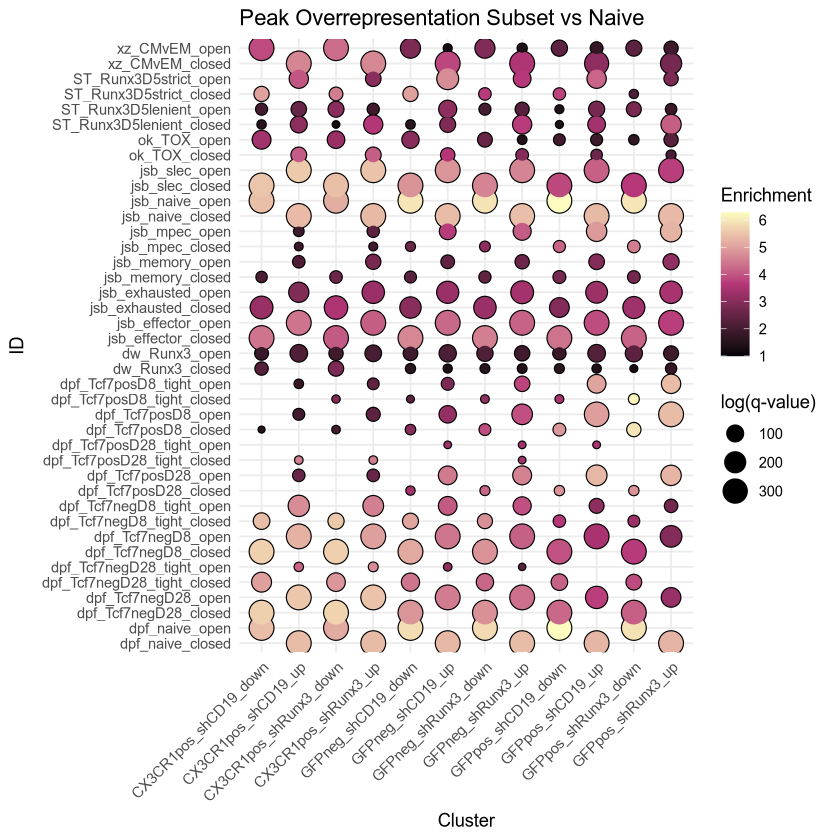

In [9]:
subset_vs_naive <- significant_df %>% 
    filter(!grepl("_vs_", comparison))
print(plotORAbubble(    subset_vs_naive,
                        "Subset vs Naive",
                        color_scale = viridis::magma(3)
                    ))

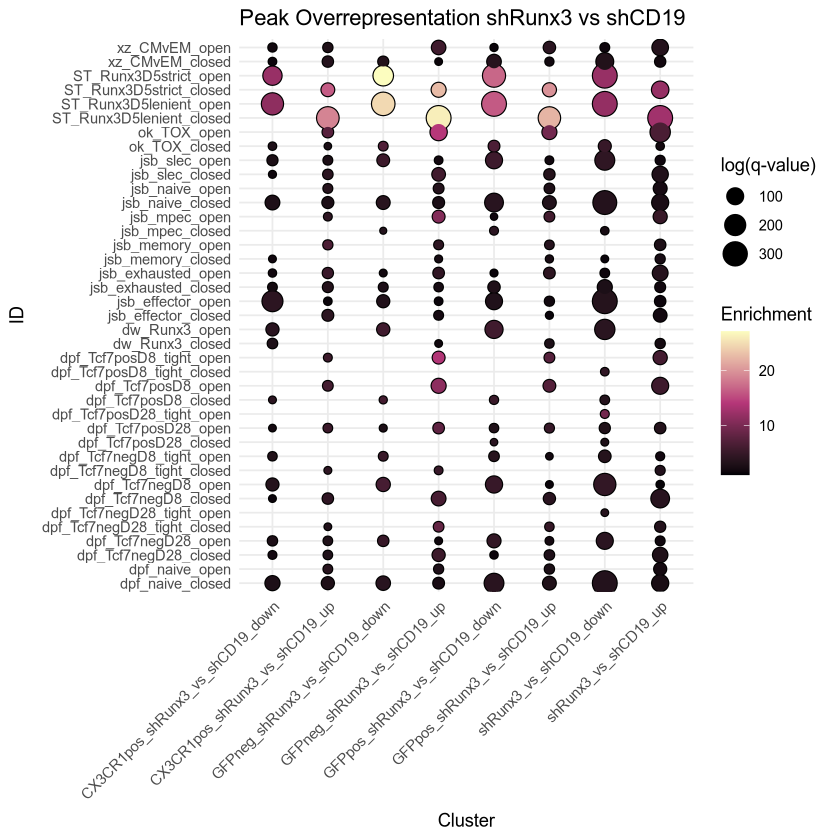

In [10]:
shRunx3_vs_shCD19 <- significant_df %>% 
    filter(grepl("shRunx3_vs", significant_df$comparison))


print(plotORAbubble(    shRunx3_vs_shCD19,
                        "shRunx3 vs shCD19",
                        color_scale = viridis::magma(3)
                    ))

In [ ]:
shRunx3_vs_shCD19 <- significant_df %>% 
    filter( grepl("shRunx3_vs", significant_df$comparison) &
            !grepl("ST", significant_df$ID))

print(plotORAbubble(shRunx3_vs_shCD19, "shRunx3 vs shCD19 (no ST Sigs)", color_scale = viridis::magma(3)))

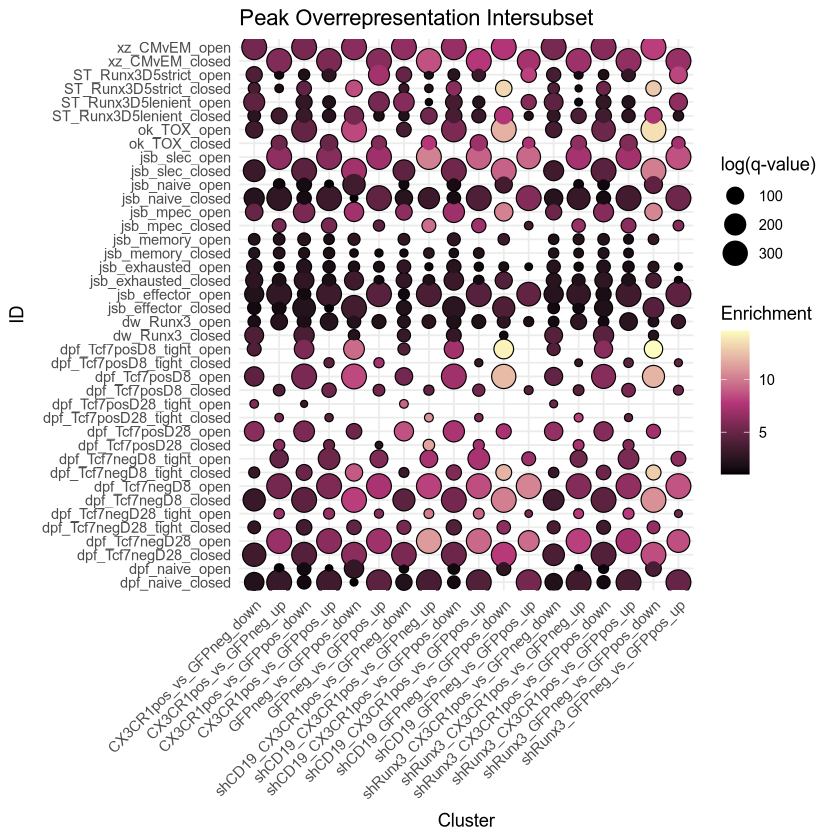

In [11]:
intersubset <- significant_df %>% 
    filter(grepl("_vs_", significant_df$comparison) & !grepl("shRunx3_vs_", significant_df$comparison))

print(plotORAbubble(    intersubset,
                        "Intersubset",
                        color_scale = viridis::magma(3)
                    ))